In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from statistics import *
import cv2
import matplotlib.pylab as plt
import os
from matplotlib import pyplot as plt
import shutil, sys  
from sklearn.metrics import confusion_matrix
import itertools

plt.ion()   # interactive mode

In [ ]:
%matplotlib inline

Se monta el drive, no es necesario se se una una computadora local

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

/
Mounted at /content/gdrive


Procesamos las imagenes para que el modelo las pueda leer

In [ ]:
def image_loader2(image):
    from PIL import Image
    import cv2
    imsize = 256
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

Funcion que hace la clasificacion sobre una imagen  y regresa, la confianza de la prediccion y el indice con respecto al archivo txt donde se encuentren las clases

In [ ]:
def detect(net,image,class_names):
  image = image_loader2(image)
  output = net(image)
  _, predicted = torch.max(output, 1)
  confidence=torch.nn.functional.softmax(output, dim=1)[0]
  confidence=confidence[predicted[0]].item()*100
  classification1 = predicted.data
  #print(int(classification1))
  index = int(classification1)
  #names = net.classes
  return confidence,class_names[index]

Algoritmo que hace la deteccion, se le entrega el path de la imagen, un ancho y un largo correspondiente al tamaño mas grande de una bounding box, despues esa bounding box sera reducida en un 20 y 40 por ciento, y cada recuadro se le aplicara un deteccion, el cuadro que tengo mayor inferencia y sobre pase el confidence establecido sera la inferencia del modelo. Este recuadro que se propuso al principio recorrera toda la imagen repitiendo el proceso previamente dicho. Alfinal la imagen con las predicciones sera guardada en la direccion que se establezca.

In [ ]:
def SSD_detection(path,w,h,model_conv):
  pred=[]
  class_pred=[]
  loc=[]
  div=1
  w=mean(w)
  h=mean(h)
  image=cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ih , iw,_=image.shape
  w2=int(iw/w)
  h2=int(ih/h)
  w=int(w)
  h=int(h)
  for x in range(w2):
    for y in range(h2):
      #Posicion boundig box grande
      y1=h*y
      y2=h*y+h
      x1=w*x
      x2=w*x+w
      #Posicion boundig box mediana
      x2_2=x1+int((x2-x1)*.8)
      y2_2=y1+int((y2-y1)*.8)
      y1_1=y1+int((x2-x1)*.2)
      x1_1=x1+int((y2-y1)*.2)
      #Posicion boundig box chica
      x2_3=x1+int((x2-x1)*.6)
      y2_3=y1+int((y2-y1)*.6)
      y1_3=y1+int((x2-x1)*.4)
      x1_3=x1+int((y2-y1)*.4)
      
      #imagen completa
      im=image[y1:y2 , x1:x2]

      pil_image=Image.fromarray(im)
      conf,label=detect(model_conv,pil_image,class_names)
      pred.append(conf)
      class_pred.append(label)
      loc.append([y1,y2,x1,x2])
      
      #imagen reduccion 1
      im2=image[y1_1:y2_2 , x1_1:x2_2]

      pil_image2=Image.fromarray(im2)
      conf,label=detect(model_conv,pil_image2,class_names)
      pred.append(conf)
      class_pred.append(label)
      loc.append([y1_3,y2_3,x1_3,x2_3])

      #imagen reduccion 2
      im2=image[y1_1:y2_2 , x1_1:x2_2]

      pil_image2=Image.fromarray(im2)
      conf,label=detect(model_conv,pil_image2,class_names)
      pred.append(conf)
      class_pred.append(label)
      loc.append([y1_1,y2_2,x1_1,x2_2])

      #Checar mejor prediccion
      conf=max(pred)
      if conf>=90 and conf< 94:
        elemento=pred.index(conf)
        label=class_pred[elemento]
        points=loc[elemento]
        text="Detectado= "+str(label)
        text2="Confianza= "+str(conf)
        y1=points[0]
        y2=points[1]
        x1=points[2]
        x2=points[3]
        print(text)
        print(text2)
        cv2.rectangle(image,(x1,y1),(x2,y2),(50,100,150),3)
        cv2.putText(image,str(text),(x1,y1+30),cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0, 0, 255),thickness = 2,lineType= cv2.LINE_4, bottomLeftOrigin=False)
        cv2.putText(image,str(text2),(x1,y2-30),cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0, 0, 255),thickness = 2,lineType= cv2.LINE_4, bottomLeftOrigin=False)
      pred.clear()
      class_pred.clear()
      loc.clear()
  cv2.imwrite('/content/gdrive/MyDrive/SSD/prediction_vgg19_2.jpg',image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.show()


Se llama el archivo txt que contenga la clases del modelo

In [ ]:
class_names=[]
class2=open('/mydrive/SSD/class_names2.txt','r')
class2=class2.readlines()
class2 = [x.strip() for x in class2] 
for x in class2:
  x=x.replace("n/ ","")
  class_names.append(x)
class_names.remove('')
print (class_names)


['AGLOMERACIÓNBASURA', 'CABLES', 'CHAPASUELTA-LAMINASUELTA', 'CUERDA', 'MADERA', 'OXIDO', 'TUBO']


Se llama el modelo, se carga y se pone en modo evaluacion, despues se pone la ruta de la imagen a predecir, y se aplica la deteccion

Detectado= CABLES
Confianza= 91.08625650405884
Detectado= CABLES
Confianza= 91.58983826637268
Detectado= CHAPASUELTA-LAMINASUELTA
Confianza= 91.7920470237732
Detectado= CABLES
Confianza= 90.03543853759766
Detectado= CABLES
Confianza= 93.49173903465271
Detectado= CABLES
Confianza= 91.21030569076538
Detectado= CABLES
Confianza= 91.97129607200623
Detectado= CABLES
Confianza= 93.06889772415161
Detectado= CABLES
Confianza= 90.70963263511658
Detectado= CABLES
Confianza= 91.71441197395325
Detectado= CABLES
Confianza= 90.37008881568909
Detectado= CABLES
Confianza= 92.1050488948822
Detectado= CABLES
Confianza= 93.2532787322998
Detectado= CABLES
Confianza= 93.84417533874512
Detectado= CABLES
Confianza= 91.25064611434937
Detectado= CABLES
Confianza= 93.94476413726807
Detectado= CABLES
Confianza= 90.82273244857788
Detectado= CHAPASUELTA-LAMINASUELTA
Confianza= 91.33462905883789
Detectado= CABLES
Confianza= 93.28500032424927
Detectado= CHAPASUELTA-LAMINASUELTA
Confianza= 90.27360677719116
Detectado

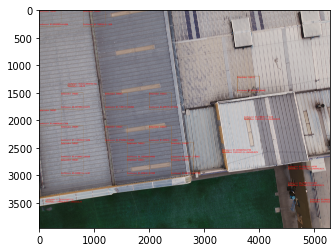

In [ ]:
path='/mydrive/SSD/model_vgg19.pth'

model=torch.load(path)
model.eval()
img='/content/gdrive/Shareddrives/Proyecto integrador de tecnologias emergentes/dataSets/data3/2018-05-10_13-21-02.JPG'
SSD_detection(img,[400],[300],model)